In [27]:
%pip install pandas numpy scikit-learn matplotlib seaborn


Note: you may need to restart the kernel to use updated packages.


In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
import joblib

# Cargar el dataset
df = pd.read_csv('Loan_Default.csv')


COLUMNAS_CLAVE = [
    'Credit_Score', 'income', 'dtir1', 'loan_amount', 'LTV', 'property_value',
    'open_credit', 'credit_type', 'co-applicant_credit_type', 'loan_type',
    'loan_purpose', 'term', 'age', 'Gender', 'approv_in_adv',
    'business_or_commercial', 'occupancy_type', 'total_units', 'Region',
    'Secured_by', 'Security_Type', 'submission_of_application',
    'construction_type', 'loan_limit', 'Neg_ammortization',
    'interest_only', 'lump_sum_payment','Credit_Worthiness','rate_of_interest', 
    'Interest_rate_spread', 'Upfront_charges',   'Status' # 'Status' es la variable objetivo 
]

df_trabajo = df[COLUMNAS_CLAVE].copy()
print(f"total de filas: {len(df_trabajo)}")

total de filas: 148670


2. Comprension de los datos (EDA)

2.1. Tipos de datos 

In [29]:
print("## 2.1. Inspección Inicial")
print(df_trabajo.head())
print("-" * 50)
print(df_trabajo.info())

## 2.1. Inspección Inicial
   Credit_Score   income  dtir1  loan_amount        LTV  property_value  \
0           758   1740.0   45.0       116500  98.728814        118000.0   
1           552   4980.0    NaN       206500        NaN             NaN   
2           834   9480.0   46.0       406500  80.019685        508000.0   
3           587  11880.0   42.0       456500  69.376900        658000.0   
4           602  10440.0   39.0       696500  91.886544        758000.0   

  open_credit credit_type co-applicant_credit_type loan_type  ...  \
0        nopc         EXP                      CIB     type1  ...   
1        nopc        EQUI                      EXP     type2  ...   
2        nopc         EXP                      CIB     type1  ...   
3        nopc         EXP                      CIB     type1  ...   
4        nopc        CRIF                      EXP     type1  ...   

  construction_type  loan_limit Neg_ammortization interest_only  \
0                sb          cf         

2.2. Valores Nulos

In [30]:
print("\n## 2.2. Conteo y Porcentaje de Valores Nulos")
null_counts = df_trabajo.isnull().sum()
null_percentages = (null_counts / len(df_trabajo)) * 100
null_info = pd.DataFrame({'Count': null_counts, 'Percentage': null_percentages})
print(null_info[null_info['Count'] > 0].sort_values(by='Percentage', ascending=False))


## 2.2. Conteo y Porcentaje de Valores Nulos
                           Count  Percentage
Upfront_charges            39642   26.664425
Interest_rate_spread       36639   24.644515
rate_of_interest           36439   24.509989
dtir1                      24121   16.224524
property_value             15098   10.155378
LTV                        15098   10.155378
income                      9150    6.154571
loan_limit                  3344    2.249277
approv_in_adv                908    0.610749
age                          200    0.134526
submission_of_application    200    0.134526
loan_purpose                 134    0.090133
Neg_ammortization            121    0.081388
term                          41    0.027578


2.3. Análisis de la Variable Objetivo

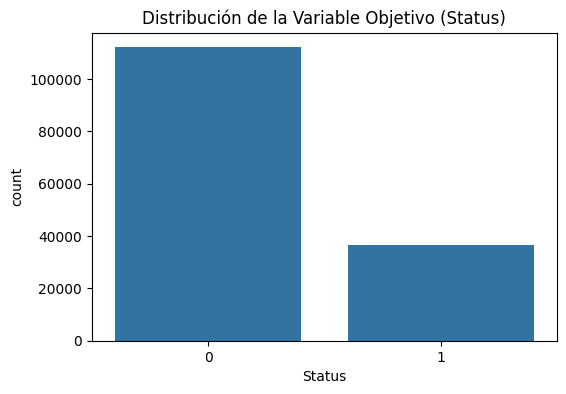


## 2.3. Proporción de Clases (Status)
Bajo Riesgo (0): 75.36%
Alto Riesgo (1): 24.64%


In [31]:
plt.figure(figsize=(6, 4))
sns.countplot(x='Status', data=df_trabajo)
plt.title('Distribución de la Variable Objetivo (Status)')
plt.show()

status_counts = df_trabajo['Status'].value_counts(normalize=True) * 100
print("\n## 2.3. Proporción de Clases (Status)")
print(f"Bajo Riesgo (0): {status_counts[0]:.2f}%")
print(f"Alto Riesgo (1): {status_counts[1]:.2f}%")

2.4. Correlación y Distribuciones 

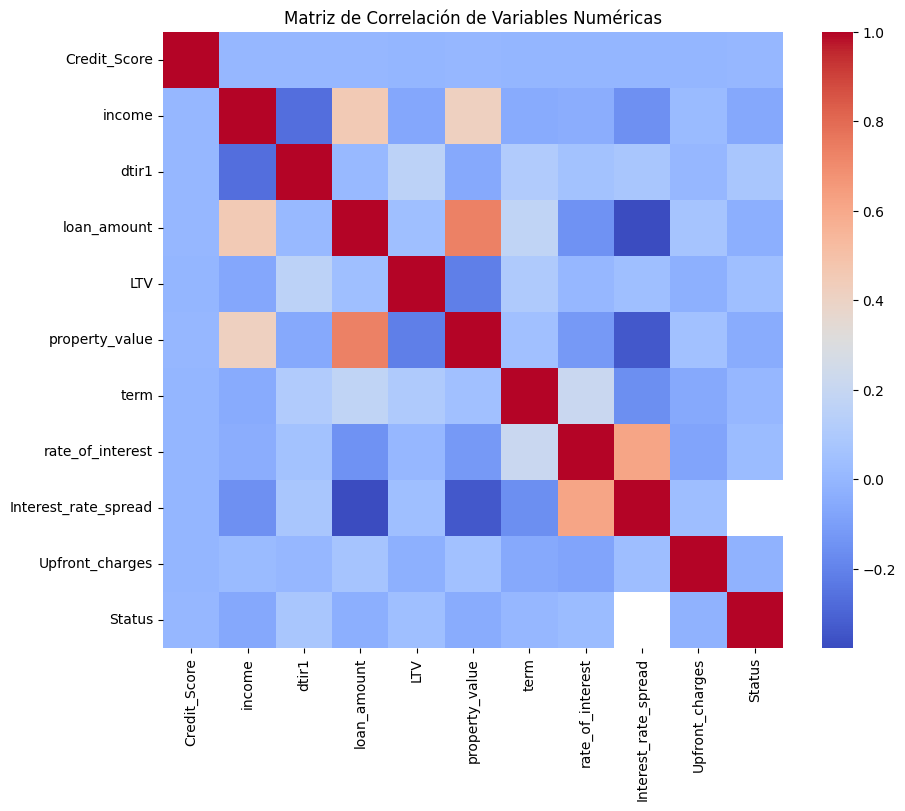

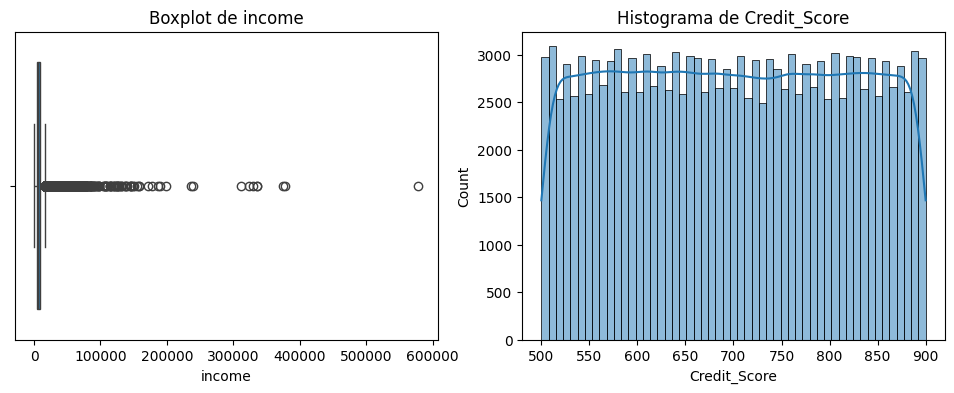

In [32]:
df_numeric = df_trabajo.select_dtypes(include=np.number)

# Matriz de Correlación
plt.figure(figsize=(10, 8))
sns.heatmap(df_numeric.corr(), annot=False, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación de Variables Numéricas')
plt.show()

# Distribuciones clave 
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.boxplot(x=df_trabajo['income'])
plt.title('Boxplot de income')

plt.subplot(1, 2, 2)
sns.histplot(df_trabajo['Credit_Score'].dropna(), kde=True)
plt.title('Histograma de Credit_Score')
plt.show()

3. Preparacion de datos 

3.1. Division de datos

In [33]:
if 'df_trabajo' in locals() and not df_trabajo.empty:
    
    X = df_trabajo.drop('Status', axis=1)
    y = df_trabajo['Status']

    # Identificar tipos de columnas
    numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_features = X.select_dtypes(include=['object', 'bool']).columns.tolist()

    # División en conjuntos de entrenamiento y prueba 
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    print(f"Datos divididos: X_train.shape={X_train.shape}, X_test.shape={X_test.shape}")

    # Pipeline para variables numéricas
    numerical_pipeline = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    # Pipeline para variables categóricas 
    categorical_pipeline = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    # Combinar ambos pipelines con ColumnTransformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_pipeline, numerical_features),
            ('cat', categorical_pipeline, categorical_features)
        ],
        remainder='drop'
    )
    print("✅ Preprocesador (preprocessor) definido.")

Datos divididos: X_train.shape=(118936, 31), X_test.shape=(29734, 31)
✅ Preprocesador (preprocessor) definido.


3.2. Creación del Pipeline de Preprocesamiento

4. Modelado y Evaluación

4.1. Pipeline del Modelo KNN

4.2. Pipeline del Modelo SVM

despliegue 

Usando muestra reducida para el ajuste de hiperparámetros: 11893 filas.
Esto reduce el tamaño de 118936 a 11893 filas.

### 4. Modelado: Entrenamiento y Ajuste de Hiperparámetros (KNN)
Fitting 3 folds for each of 6 candidates, totalling 18 fits

### 4. Modelado: Entrenamiento y Ajuste de Hiperparámetros (SVM)
Fitting 3 folds for each of 4 candidates, totalling 12 fits

### 5. Evaluación: Resultados en el Conjunto de Prueba

--- Resultados para KNN ---
Mejores Parámetros: {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 10, 'p': 2, 'weights': 'distance'}
              precision    recall  f1-score   support

           0       0.92      0.97      0.94     22406
           1       0.88      0.75      0.81      7328

    accuracy                           0.91     29734
   macro avg       0.90      0.86      0.88     29734
weighted avg       0.91      0.91      0.91     29734

AUC-ROC: 0.9615


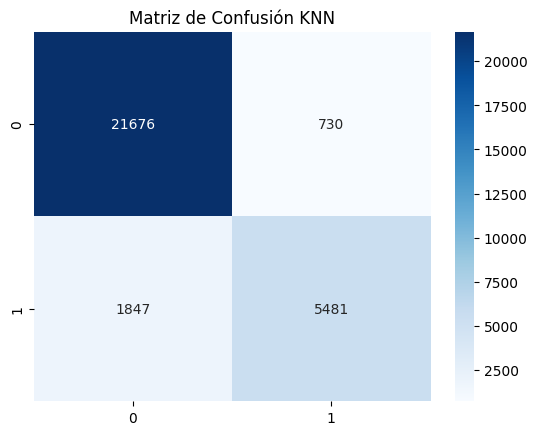


--- Resultados para SVM ---
Mejores Parámetros: {'C': 1, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': True, 'random_state': 42, 'shrinking': True, 'tol': 0.001, 'verbose': False}
              precision    recall  f1-score   support

           0       0.94      0.99      0.96     22406
           1       0.95      0.81      0.88      7328

    accuracy                           0.94     29734
   macro avg       0.95      0.90      0.92     29734
weighted avg       0.94      0.94      0.94     29734

AUC-ROC: 0.9873


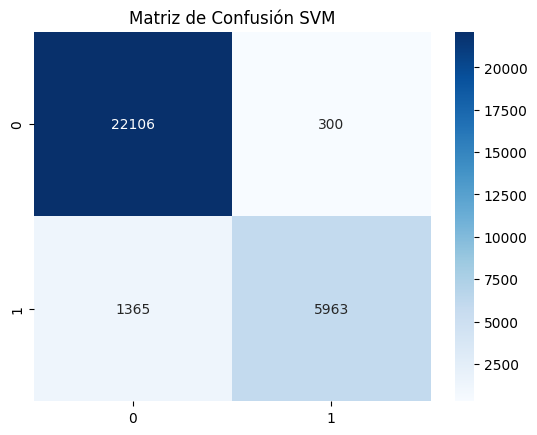


### Comparación Final de Modelos
     Accuracy Recall (Default) F1-Score (Default)   AUC-ROC
KNN  0.913332         0.747953           0.809661  0.961511
SVM  0.944003         0.813728           0.877492   0.98729

✅ El **Mejor Modelo** (basado en Recall para la clase Default) es: **SVM**.

Modelo ganador (mejor recall) guardado como 'best_credit_risk_model.pkl'.
Modelo KNN optimizado guardado como 'knn_optimized_model.pkl'.
Modelo SVM optimizado guardado como 'svm_optimized_model.pkl'.


In [34]:
if 'df' in locals() and not df.empty:

    try:

        from sklearn.model_selection import train_test_split
        
        X_sample, _, y_sample, _ = train_test_split(
            X_train, y_train, 
            test_size=0.9, 
            random_state=42, 
            stratify=y_train 
        )
        
        print(f"Usando muestra reducida para el ajuste de hiperparámetros: {X_sample.shape[0]} filas.")
        print(f"Esto reduce el tamaño de {X_train.shape[0]} a {X_sample.shape[0]} filas.")

    except NameError:
        print("Variables X_train o y_train no definidas. No se puede crear la muestra. Usando el conjunto completo.")
        X_sample, y_sample = X_train, y_train 
    except Exception as e:
        print(f"Error al muestrear: {e}. Usando el conjunto completo.")
        X_sample, y_sample = X_train, y_train 

    # 4.1. Definición de Modelos (KNN y SVM)

    # 4.2. Pipeline completo para KNN
    knn_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', KNeighborsClassifier())
    ])

    # 4.3. Pipeline completo para SVM
    svm_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', SVC(probability=True, random_state=42)) 
    ])

    # 4.4. Ajuste de Hiperparámetros 

    # Parámetros para KNN
    param_grid_knn = {
        'classifier__n_neighbors': [5, 10, 15],
        'classifier__weights': ['uniform', 'distance']
    }

    # Parámetros para SVM 
    param_grid_svm = {
        'classifier__C': [0.1, 1],
        'classifier__kernel': ['linear', 'rbf']
    }


    print("\n### 4. Modelado: Entrenamiento y Ajuste de Hiperparámetros (KNN)")
    grid_search_knn = GridSearchCV(knn_pipeline, param_grid_knn, cv=3, scoring='f1_weighted', n_jobs=-1, verbose=1)
    # AJUSTE CON LA MUESTRA REDUCIDA
    grid_search_knn.fit(X_sample, y_sample) 
    best_knn = grid_search_knn.best_estimator_

    print("\n### 4. Modelado: Entrenamiento y Ajuste de Hiperparámetros (SVM)")
    grid_search_svm = GridSearchCV(svm_pipeline, param_grid_svm, cv=3, scoring='f1_weighted', n_jobs=-1, verbose=1)
    # AJUSTE CON LA MUESTRA REDUCIDA
    grid_search_svm.fit(X_sample, y_sample)
    best_svm = grid_search_svm.best_estimator_


    # -----------------------------------------------------------
    # 5. Evaluación (Usa el conjunto de PRUEBA COMPLETO: X_test, y_test)
    # -----------------------------------------------------------

    models = {
        'KNN': best_knn,
        'SVM': best_svm
    }

    results = {}

    print("\n### 5. Evaluación: Resultados en el Conjunto de Prueba")
    for name, model in models.items():
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]

        report = classification_report(y_test, y_pred, output_dict=True)
        auc_score = roc_auc_score(y_test, y_proba)

        results[name] = {
            'Accuracy': accuracy_score(y_test, y_pred),
            'Recall (Default)': report['1']['recall'],
            'F1-Score (Default)': report['1']['f1-score'],
            'AUC-ROC': auc_score,
            'Report': report
        }

        print(f"\n--- Resultados para {name} ---")
        print(f"Mejores Parámetros: {model.named_steps['classifier'].get_params()}")
        print(classification_report(y_test, y_pred))
        print(f"AUC-ROC: {auc_score:.4f}")
        sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
        plt.title(f'Matriz de Confusión {name}')
        plt.show()

    # 5.2. Conclusión del Modelo (Comparación Final)
    results_df = pd.DataFrame(results).T
    print("\n### Comparación Final de Modelos")
    print(results_df[['Accuracy', 'Recall (Default)', 'F1-Score (Default)', 'AUC-ROC']])

    best_model_name = results_df['Recall (Default)'].idxmax()
    best_model = models[best_model_name]
    print(f"\n✅ El **Mejor Modelo** (basado en Recall para la clase Default) es: **{best_model_name}**.")

    # ------------------------------------------------------------------
    # 5.3. Modificación para Guardar AMBOS Modelos (KNN y SVM)
    # ------------------------------------------------------------------

    # Guardar el MEJOR modelo (basado en la métrica Recall)
    joblib.dump(best_model, 'best_credit_risk_model.pkl')
    print("\nModelo ganador (mejor recall) guardado como 'best_credit_risk_model.pkl'.")

    # Guardar el modelo KNN optimizado
    joblib.dump(best_knn, 'knn_optimized_model.pkl')
    print("Modelo KNN optimizado guardado como 'knn_optimized_model.pkl'.")

    # Guardar el modelo SVM optimizado
    joblib.dump(best_svm, 'svm_optimized_model.pkl')
    print("Modelo SVM optimizado guardado como 'svm_optimized_model.pkl'.")
